# Scattering by nanoplasmonic mesoscale assemblies: [Tuining Diffraction](https://doi.org/10.1364/JOSAA.560629)

## Intoduction

We studied scattering by nano-assembled plasmonic mesoscale structures formed by a dielectric spherical core coated with a concentric shell containing a random distribution of gold nanoparticles (AuNPs). Building on a multiscale framework that treats nanoparticle–light interactions and the core response consistently, we use this platform to quantify how controlled disorder in the AuNP shell redistributes scattered power. In our work on [Scattering by nanoplasmonic mesoscale assemblies,](https://doi.org/10.1364/JOSAA.560629) we sweep AuNP diameters (5–20 nm) and filling fractions (0.1–0.3) and compute angular scattering patterns, showing that the coating can suppress side lobes and bias scattering forward. The results highlight tunable spatial and spectral control of scattering profiles and suggest applications in passive cloaking and high-resolution imaging.

**TL;DR.**
In our research we showed that a dielectric core with a disordered AuNP shell can be used to tune the differential scattering cross-section(diffraction) to steer overall scattering forward and reduce angular side lobes, offering a practical route to mesoscale optical modulation.

### Citation
Imran Khan *et al.*, “Mesoscale optical scattering control using nano-assembled plasmonic shells,” *JOSA A* (2025).  
DOI: https://doi.org/10.1364/JOSAA.560629


## Table of Contents

- [Computation method](#computational-method-overview)
- [Environment Bootstrap](#environment-bootstrap)
- [Parameters](#parameters--config)
- [Scattering Models & Fits](#scattering-models--fits)
- [Main execution loop](#main-execution-loop)
- [Anisotropy plot](#wavelength-dependent-anisotropy-plot)
- [Far-field scattering pattern](#superimposed-polar-plot-of-the-far-filed-scattering-pattern)
- [Polar plot of $\sigma_{d}$](#on-demand-polar-plot-of-)
- [Key findings](#key-findings--conclusions)

### Computational method (overview)
We model a nanoplasmonic mesoscale assembly by a dielectric core(radius: $a_{0}$) surrounded by randomly distributed plasmonic gold nanoparticles(AunP). The amount of perturbation can be controlled by volume filling fraction ($V_{ff}$).  Incident light scattered by the dielectric core and the plasmonic nanoparticles in the shell. These nanoparticles are placed at a sub-nanometer distance from the core. The total interaction between the     core-plasmonic nanoparticles and among themselves creates a strong multiple scattering.

- **Nanoparticle response** via multiple scattering (Foldy–Lax) with effective phase interactions inside the shell.
- **Core response** via a boundary method (e.g., Method of Fundamental Solutions).

From the total field we compute:
- **Differential scattering cross-section:** $\sigma_{d}(\hat{o},\hat{\mathcal i }) = |\mathcal f (\hat{o},\hat{i})|^{2}$
- **Total scattering:** $\sigma_{t} = \frac{4\pi}{k_{0}}$ Im ${\mathrm f (\hat{i}, \hat{i})}$
- **Scattering Albedo:** $\bar{\omega}_{0}$ = $\sigma_{s}$ /$\sigma_{t}$. When $\bar{\omega}_{0} = 1$, extinction is due entirely to scattering,
    and when $\bar{\omega}_{0}=0$ it is due entirely to absorption.  
- **Anisotropy:** $g = \frac{1}{\sigma_{t}}\int_{4\pi}(\hat{o}.\hat{i}) \sigma_{d}(\hat{o},\hat{i})d\hat{o}$. The Anisotropy factor ($g$) gives a measure for the amount of power flow in forward/backward direction. When $g=0$ scattering is isotropic and when $g=\pm 1$ scattering is purely in the forward or backward direction, respectively.

- **Henyey-Greenstein** scattering law was used for curve fitting and extracting $g$ from differential scattering scross-section $\sigma_{d}^{HG}(\theta) = \frac{\sigma_s}{4\pi}\frac{1-g^{2}}{(1+g^{2}-2g\cos\theta)^{3/2}} $

A detailed derivation can be found in our [publication.](https://doi.org/10.1364/JOSAA.560629)



Functions in the modules **Geometry** and **Mfs** were developed as a part of our earlier work on multiscale plasmonic cloaking platform,
[Modeling broadband cloaking using 3D nano-assembled plasmonic meta-structures](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-28-15-22732&id=433552).


Below, we keep code modular: core physics in pure functions, then a single main loop to produce arrays for plotting.

## Environment bootstrap


In [1]:
# Install-if-missing, then imports
try:
    import tqdm  
except ModuleNotFoundError:
    %pip install -q tqdm

import os, random, math, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from src import Geometry,Mfs


## Parameters / Config

In [2]:
# --- Load wavelength and refractive index ---
Refractive_index_data = 'data/optical_constants/20nm_gold_film_silica.csv'
Raw_data = open(Refractive_index_data,'rt')
data = np.loadtxt(Raw_data,delimiter=",") # processed data
Wavelength = np.asarray(data[:,0]) # list of visible wavelength values
NPRefndx  = np.asarray(data[:,1]) # refractive index
NPExtinction  = np.asarray(data[:,2]) # Extinction coefficients of metal NPs
Silica_refndx = data[:,3] # silica refractive index

#--- set parameters ---
nb = 1.0
# silica core diameter
CoreDia = 690.0 # size in nm
a0 = CoreDia/2 # silica-core radius
NPDia = 20.0 # Naoparticle size in nn
R = NPDia / 2 #radius of plasmonic NP
Vff = 0.05 # NP filling fraction in the shell 
M = 512 # number of MSF points
D = 64 # point Gauss_legendre integration

#Compute the geometric cross-section
σ_g = np.pi * a0 ** 2 # bare core
σ_g_cs = np.pi * (a0+NPDia*3) ** 2 # core-shell
# Set refractive index
k0 = nb # Refractive index exterior or the background

#Compute the MFS points

ν, ρ_bdy, ρ_int, ρ_ext = Mfs.ComputeMFSPoints( a0, M )

## Scattering Models & Fits

In [3]:

# Define HG function
def HG_function(mu, albedo, g):
    return (albedo / (4 * np.pi)) * (1 - g**2) / (1 + g**2 - 2 * g * mu)**(3/2)

def compute_scattering_amplitude(k0, ρ_ext, R_N, c_ext, psi_Ex, alpha, MU, PHI):
    """
    Compute scattering amplitude for given coefficients and geometry
    """
    num_points = len(MU)
    f_d = np.zeros_like(MU, dtype=complex)
    
    for p in range(num_points):
        sin_theta = np.sqrt(1.0 - MU[p]**2)
        cos_phi, sin_phi = np.cos(PHI[p]), np.sin(PHI[p])
        
        # Phase calculations
        phase = (sin_theta * cos_phi * ρ_ext[:, 0] + 
                 sin_theta * sin_phi * ρ_ext[:, 1] + 
                 MU[p] * ρ_ext[:, 2])
        
        phase_R_N = (sin_theta * cos_phi * R_N[:, 0] + 
                     sin_theta * sin_phi * R_N[:, 1] + 
                     MU[p] * R_N[:, 2])
        
        # Scattering amplitude components
        term1 = np.exp(-1j * k0 * phase)
        integral1 = np.dot(term1, c_ext) / (4.0 * np.pi)
        
        term2 = alpha * np.exp(-1j * k0 * phase_R_N)
        integral2 = np.dot(term2, psi_Ex) / (4.0 * np.pi)
        
        f_d[p] = integral1 + integral2
    
    return f_d

def compute_cross_sections(f_d, MU, WTS):
    """
    Compute differential, scattering, and anisotropy from scattering amplitude
    - sigma_s : cross-section using product Gauss quadreture rule by Atkinson
    - Anisotropy(g) computing the first moment of the differential cross-section normalized by 
      sigma_s
    """
    sigma_d = np.abs(f_d) ** 2
    sigma_s = np.sum(sigma_d * WTS) 
    g = np.sum(sigma_d * MU * WTS) / sigma_s
    return sigma_d, sigma_s, g

def fit_HG_model(sigma_d, sigma_t, MU, x0=[1.0, 0.9]):
    """
    Fit Henyey-Greenstein model to differential cross-section
    """
    sigma_d_normalized = sigma_d / sigma_t
    popt, _ = curve_fit(HG_function, MU, sigma_d_normalized, p0=x0)
    return popt[0], popt[1]  # albedo_fit, g_fit

def setup_quadrature(D=64):
    """
    Set up Gauss-Legendre quadrature points and weights
    """
    mu, wt = Mfs.GaussLegendre(D)
    phi = np.linspace(0, 2*np.pi, 2*D, endpoint=False)
    MU, PHI = np.meshgrid(mu, phi)
    WTS, _ = np.meshgrid(wt, phi)
    return MU.ravel(), PHI.ravel(), (WTS * (np.pi / D)).ravel()

## Main Execution Loop

In [4]:
# Initialize results
results_core = np.zeros((len(Wavelength), 6))        
results_core_shell = np.zeros((len(Wavelength), 6))  

# Setup quadrature 
MU, PHI, WTS = setup_quadrature(D=64)

# Generate nanoparticle Coordinates
R_N = Geometry.Coordinates(CoreDia, NPDia, Vff)
N = len(R_N)
try :
    # Main execution loop 
    for i in tqdm(range(len(Wavelength)), desc="Processing wavelengths"):
        WL = Wavelength[i]
        n = NPRefndx[i]
        K = NPExtinction[i]
        k0 = (2*np.pi/WL)*nb
        k1 = (2*np.pi/WL)*Silica_refndx[i]
        
        # --- CORE ONLY CALCULATION ---
        c_int_core, c_sca_core = Mfs.ComputeMFSExpansionCoefficients(
            k0, k1, a0, ν, ρ_bdy, ρ_int, ρ_ext, M)
        
        # Optical theorem for total cross-section
        f_forward = np.dot(np.exp(-1j * k0 * ρ_ext[:, 2]), c_sca_core) / (4.0 * np.pi)
        sigma_t_core = (4.0 * np.pi / k0) * np.imag(f_forward)
        
        # Scattering amplitude (core only)
        f_d_core = compute_scattering_amplitude(
            k0, ρ_ext, 
            R_N=np.zeros((0, 3)),
            c_ext=c_sca_core, 
            psi_Ex=np.zeros(0),
            alpha=0.0,
            MU=MU, PHI=PHI
        )
        
        #sigma_d_core, sigma_s_core, g_core = compute_cross_sections(f_d_core, MU, WTS)
        # not storing sigma_s for core as we are setting g = 1 explicitly
        sigma_d_core, _ , g_core = compute_cross_sections(f_d_core, MU, WTS)
        
        # Silica core has albedo = 1 (no absorption over visible spectrum)
        computed_albedo_core = 1.0  # sigma_s_core/sigma_t_core would also be ~1, but we enforce it
        albedo_fit_core = 1.0       # HG fit should also give 1 for pure dielectric
        
        # Fit HG for anisotropy only (fix albedo=1)
        def HG_function_fixed_albedo(mu, g):
            return (1.0 / (4 * np.pi)) * (1 - g**2) / (1 + g**2 - 2 * g * mu)**(3/2)
        
        sigma_d_core_normalized = sigma_d_core / sigma_t_core
        popt_g, _ = curve_fit(HG_function_fixed_albedo, MU, sigma_d_core_normalized, p0=[0.9])
        g_fit_core = popt_g[0]
        
        results_core[i, :] = [WL, computed_albedo_core, g_core, sigma_t_core, 
                            albedo_fit_core, g_fit_core]
        
        # --- CORE+SHELL CALCULATION ---
        alpha = Geometry.RayleighAlpha(R, WL, n, K)
        sigma_t_cs = Mfs.ComputeTotalCrossSection(k0, k1, a0, ν, ρ_bdy, ρ_int, ρ_ext, alpha, R_N, M, N)
        
        c_int_cs, c_ext_cs, psi_Ex_cs = Mfs.ComputeExpansionCoefficientsExcitingFields(
            k0, k1, a0, ν, ρ_bdy, ρ_int, ρ_ext, alpha, R_N, M, N)
        
        f_d_cs = compute_scattering_amplitude(
            k0, ρ_ext, R_N, c_ext_cs, psi_Ex_cs, alpha, MU, PHI)
        
        sigma_d_cs, sigma_s_cs, g_cs = compute_cross_sections(f_d_cs, MU, WTS)
        
        # Core+Shell: Use actual computed values (gold nanoparticles absorb)
        computed_albedo_cs = sigma_s_cs / sigma_t_cs
        
        # Fit HG for both parameters for core+shell
        sigma_d_cs_normalized = sigma_d_cs / sigma_t_cs
        popt_cs, _ = curve_fit(HG_function, MU, sigma_d_cs_normalized, p0=[computed_albedo_cs, g_cs])
        albedo_fit_cs, g_fit_cs = popt_cs
        
        results_core_shell[i, :] = [WL, computed_albedo_cs, g_cs, sigma_t_cs, 
                                albedo_fit_cs, g_fit_cs]
        
        # Progress output : uncomment if you like to see verbose 
        #print(f'WL: {WL}nm | Core: g={g_core:.3f} | Core+Shell: g={g_cs:.3f}, albedo={computed_albedo_cs:.3f}')
    # loop ends here

    # Save results as CSV files

    os.makedirs('results', exist_ok=True)

    # Core results
    core_df = pd.DataFrame(results_core, 
                        columns=['Wavelength_nm', 'Computed_Albedo', 'Computed_g', 
                                'Total_CrossSection', 'HG_Albedo', 'HG_g'])
    core_filename = f'results/data/core_{CoreDia}nm_results.csv'
    core_df.to_csv(core_filename, index=False, float_format='%.6f')

    # Core+Shell results
    core_shell_df = pd.DataFrame(results_core_shell,
                                columns=['Wavelength_nm', 'Computed_Albedo', 'Computed_g', 
                                        'Total_CrossSection', 'HG_Albedo', 'HG_g'])
    core_shell_filename = f'results/data/core_shell_{CoreDia}nm_{int(Vff*100)}pct_results.csv'
    core_shell_df.to_csv(core_shell_filename, index=False, float_format='%.6f')

    # Combined comparison file
    combined_data = []
    for i in range(len(Wavelength)):
        combined_data.append([
            Wavelength[i],
            # Core values
            results_core[i, 1], results_core[i, 2], results_core[i, 4], results_core[i, 5],
            # Core+Shell values  
            results_core_shell[i, 1], results_core_shell[i, 2], results_core_shell[i, 4], results_core_shell[i, 5],
            # Differences
            results_core_shell[i, 1] - results_core[i, 1],  # Albedo
            results_core_shell[i, 2] - results_core[i, 2],  # g
            results_core_shell[i, 3] - results_core[i, 3],  # Total Cross-section
                ])

    combined_df = pd.DataFrame(combined_data,
                            columns=['Wavelength_nm', 
                                    'Core_Albedo', 'Core_g', 'Core_HG_Albedo', 'Core_HG_g',
                                    'CoreShell_Albedo', 'CoreShell_g', 'CoreShell_HG_Albedo', 'CoreShell_HG_g',
                                    'Delta_Albedo', 'Delta_g', 'Delta_Total_CS'])

    combined_filename = f'results/data/comparison_{CoreDia}nm_{int(Vff*100)}pct.csv'
    combined_df.to_csv(combined_filename, index=False, float_format='%.6f')

    print(f"\nResults saved successfully!")
    print(f" Core results: {core_filename}")
    print(f"Core+Shell results: {core_shell_filename}")
    print(f"Comparison: {combined_filename}")
except Exception as e:
    print("Error occured :",e)



Processing wavelengths:   0%|          | 0/36 [00:00<?, ?it/s]


Results saved successfully!
 Core results: results/data/core_690.0nm_results.csv
Core+Shell results: results/data/core_shell_690.0nm_5pct_results.csv
Comparison: results/data/comparison_690.0nm_5pct.csv


## Wavelength-Dependent Anisotropy Plot

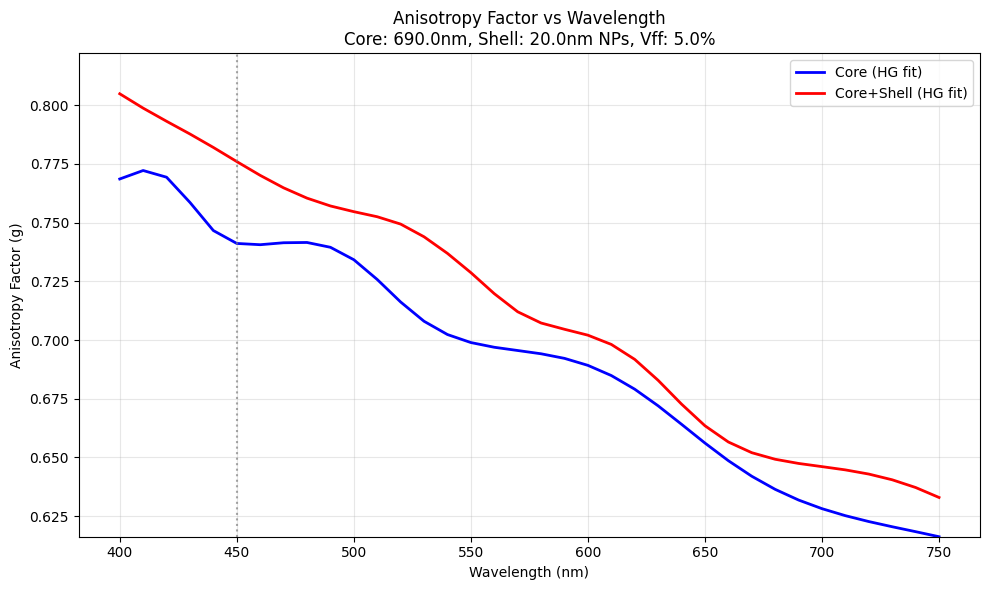

In [5]:
# Plot 1: Wavelength-dependent anisotropy comparison
try :
    plt.figure(figsize=(10, 6))

    # Load the data (or use the arrays you already have)
    core_data = np.loadtxt(f'results/data/core_{CoreDia}nm_results.csv', delimiter=',', skiprows=1)
    core_shell_data = np.loadtxt(f'results/data/core_shell_{CoreDia}nm_{int(Vff*100)}pct_results.csv', delimiter=',', skiprows=1)

    wavelengths = core_data[:, 0]  # First column is wavelength

    plt.plot(wavelengths, core_data[:, 5], 'b-', linewidth=2, label='Core (HG fit)')  # HG_g column
    plt.plot(wavelengths, core_shell_data[:, 5], 'r-', linewidth=2, label='Core+Shell (HG fit)')  # HG_g column
    #plt.plot(wavelengths, core_shell_data[:, 2], 'r--', linewidth=1.5, alpha=0.7, label='Core+Shell (computed)')  # Computed_g column

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Anisotropy Factor (g)')
    plt.title(f'Anisotropy Factor vs Wavelength\nCore: {CoreDia}nm, Shell: {NPDia}nm NPs, Vff: {Vff*100}%')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(min(core_data[:, 5]), (max(core_data[:,5])+0.05))  # g ranges from -1 to 1

    # Add vertical line at 450nm for reference
    plt.axvline(x=450, color='gray', linestyle=':', alpha=0.7, label='450 nm')

    plt.tight_layout()
    plt.savefig(f'results/figures/anisotropy_comparison_{CoreDia}nm_{int(Vff*100)}pct.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("Error occured:",e)

## Superimposed polar plot of the far-filed scattering pattern 

The plots shows superimposed scattering patterns of a 750 nm bare silica core (no nano-plasmonic shell), the same core surrounded by a shell made of randomly distributed 5nm AuNP, and  a 20 nm AuNP shell. Shell thickness was the same as the AuNP diameter and a 30% volume filling fraction (V_ff 30%). Incident light wavelengths are 450nm and 670 nm. Two extremes of the visible spectrum were explored to show how the scattering patterns change due to the plasmonic shell. 


Plot data were **pre-generated**. For a V_ff of 30%, this model requires a significant amount of time and computing resources to generate particle coordinates and solve the wave equations.

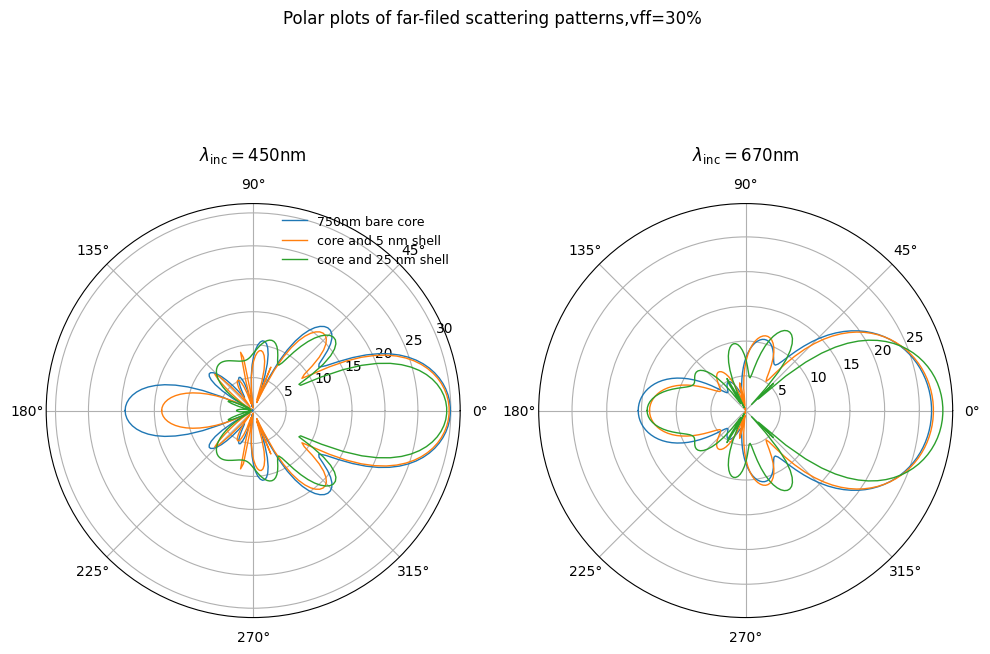

In [6]:

def load_polar_data(path,theta_col=0,value_cols=(1,2,3),delimiter=","):
    """  
    - load csv file with theta + N series.
    - returns theta, [series1:bare core values,series2 : 5 nm shell+core, series3 = 20 nm shell+core]
    """
    M = np.loadtxt(open(path,'rt'), delimiter=delimiter)
    theta = M[:,theta_col]
    series = [M[:,c] for c in value_cols]
    return theta, series

def overlapping_plots(theta, series_list, labels=None,ax = None, title = None,linewidth=1, alpha=1.0):
    if ax is None:
        ax = plt.subplot(111, projection='polar')
    th = theta
    for r in series_list:
        ax.plot(th,r,linewidth=linewidth,alpha=alpha)
    if labels:
        ax.legend(labels, loc='upper right', fontsize=9, frameon=False)
    if title:
        ax.set_title(title,pad=12)
    return ax
try:
    # --- 450nm incident wavelength---
    lambda_in_450nm = 'data/plot_data/Core_750_5nm_20nm_in_450nm.csv'
    theta1,(bare_750nm_core,core_5nm_shell, core_20nm_shell) = load_polar_data(lambda_in_450nm)
    # --- 670 nm incident wavelenth ---
    lambda_in_670nm = 'data/plot_data/Core_750_5nm_20nm_in_670nm.csv'
    theta_2,(bare_750nm_core_2,core_5nm_shell_2, core_20nm_shell_2) = load_polar_data(lambda_in_670nm)

    # --- polar plot --- 
    fig, axs = plt.subplots(1,2,figsize=(10,7),subplot_kw={'projection':'polar'})

    # ---first panel---
    ax0 = overlapping_plots(theta1,[bare_750nm_core,core_5nm_shell, core_20nm_shell],
                        labels=['750nm bare core','core and 5 nm shell', 'core and 25 nm shell'],
                        ax=axs[0],
                        title=r"$\lambda_{\mathrm{inc}} = 450\mathrm{nm}$")

    # --- second panel ---
    ax1 = overlapping_plots(theta_2, [bare_750nm_core_2,core_5nm_shell_2, core_20nm_shell_2],
                            labels=['750nm bare core','core with 5 nm shell', 'core with 25 nm shell'],
                            ax=axs[1],
                            title=r"$\lambda_{\mathrm{inc}} = 670\mathrm{nm}$"
                            )
    ax1.legend_.remove() # Legend is same for both plots
    fig.suptitle("Polar plots of far-filed scattering patterns,vff=30% ",y=1.05)
    fig.tight_layout()
    plt.show()

    """   
    for ax in axs:
        ax.set_rticks([5, 10, 15, 20, 25, 30])
    fig.savefig("results/far_field_polar.png",dpi=300,
                bbox_inches="tight")
    """
    fig.savefig("results/figures/far_field_polar.png",dpi=300,
                bbox_inches="tight")
except Exception as e:
    print("Error occured:",e)

## On demand Polar plot of $\sigma_{d}$:

Polar plot below showing an on-demand scattering pattern for a specific incident wavelength. 
You can choose any wavelength from 400 nm to 750 nm with a 10 nm interval. As an example incident wavelength $\lambda_{inc} = 450nm$ was set as default. 

Creating polar plot for wavelength: 570.0 nm


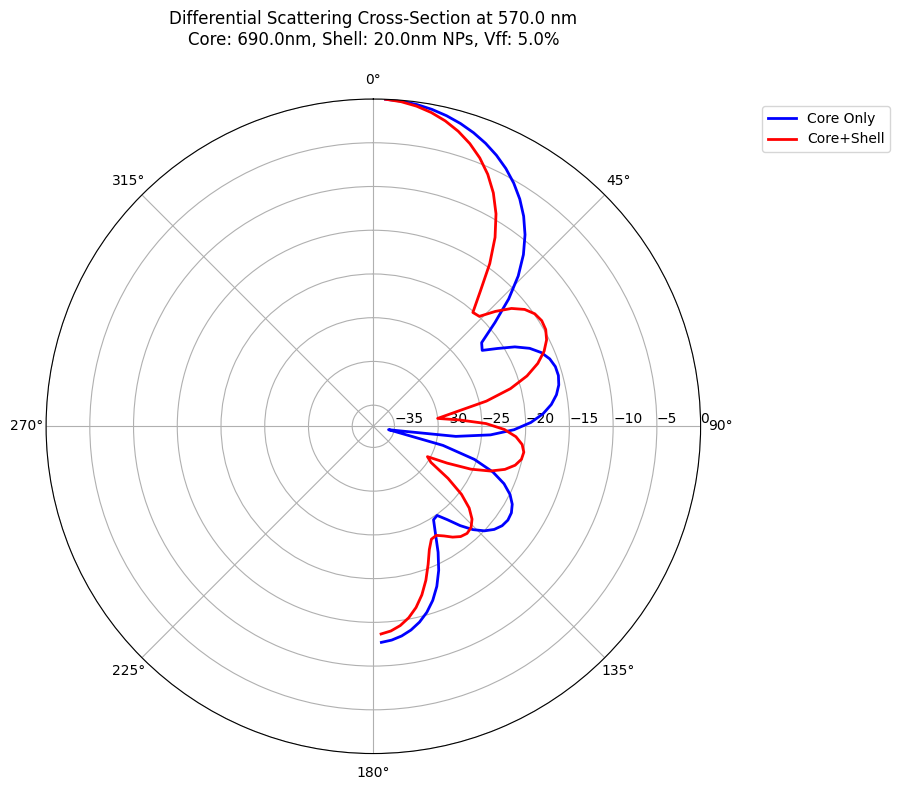

In [7]:
# Plot 3: Polar plot for a specific wavelength
# set to none, by default it will plot for 450 nm
try:

    def create_polar_plot(wavelength_target= None):
        # Find index for target wavelength
        if wavelength_target is None: 
            wavelength_target = 450
        else:
            wavelength_target = wavelength_target
        idx = np.argmin(np.abs(wavelengths - wavelength_target))
        WL_target = wavelengths[idx]
        
        print(f"Creating polar plot for wavelength: {WL_target} nm")
        
        # Recompute for this specific wavelength to get sigma_d values
        WL = WL_target
        n = NPRefndx[idx]
        K = NPExtinction[idx]
        k0 = (2*np.pi/WL)*nb
        k1 = (2*np.pi/WL)*Silica_refndx[idx]
        
        # --- CORE ONLY ---
        c_int_core, c_sca_core = Mfs.ComputeMFSExpansionCoefficients(
            k0, k1, a0, ν, ρ_bdy, ρ_int, ρ_ext, M)
        
        # --- CORE+SHELL ---
        alpha = Geometry.RayleighAlpha(R, WL, n, K)
        c_int_cs, c_ext_cs, psi_Ex_cs = Mfs.ComputeExpansionCoefficientsExcitingFields(
            k0, k1, a0, ν, ρ_bdy, ρ_int, ρ_ext, alpha, R_N, M, N)
        
        # Compute sigma_d for both cases at this wavelength
        sigma_d_core = np.zeros_like(MU)
        sigma_d_cs = np.zeros_like(MU)
        
        for p in range(len(MU)):
            sin_theta = np.sqrt(1.0 - MU[p]**2)
            cos_phi, sin_phi = np.cos(PHI[p]), np.sin(PHI[p])
            
            # Phase calculations
            phase = (sin_theta * cos_phi * ρ_ext[:, 0] + 
                    sin_theta * sin_phi * ρ_ext[:, 1] + 
                    MU[p] * ρ_ext[:, 2])
            
            phase_R_N = (sin_theta * cos_phi * R_N[:, 0] + 
                        sin_theta * sin_phi * R_N[:, 1] + 
                        MU[p] * R_N[:, 2])
            
            # Core only
            term1_core = np.exp(-1j * k0 * phase)
            integral_core = np.dot(term1_core, c_sca_core) / (4.0 * np.pi)
            sigma_d_core[p] = np.abs(integral_core) ** 2
            
            # Core+Shell
            term1_cs = np.exp(-1j * k0 * phase)
            integral1_cs = np.dot(term1_cs, c_ext_cs) / (4.0 * np.pi)
            
            term2_cs = alpha * np.exp(-1j * k0 * phase_R_N)
            integral2_cs = np.dot(term2_cs, psi_Ex_cs) / (4.0 * np.pi)
            
            sigma_d_cs[p] = np.abs(integral1_cs + integral2_cs) ** 2

        
        
        # Convert to polar coordinates for plotting
        theta = np.arccos(MU)  # theta from 0 to pi
        phi = PHI              # phi from 0 to 2pi
        
        # Reshape to 2D grid
        theta_2d = theta.reshape(2*D, D)
        phi_2d = phi.reshape(2*D, D)
        sigma_d_core_2d = sigma_d_core.reshape(2*D, D)
        sigma_d_cs_2d = sigma_d_cs.reshape(2*D, D)
        
        # Average over phi to get theta-dependent only (for polar plot)
        sigma_d_core_theta = np.mean(sigma_d_core_2d, axis=0)
        sigma_d_cs_theta = np.mean(sigma_d_cs_2d, axis=0)
        
        # Convert to dB scale (as in your MATLAB code)
        sigma_d_core_db = 10 * np.log10(sigma_d_core_theta / sigma_d_core_theta.max())
        sigma_d_cs_db = 10 * np.log10(sigma_d_cs_theta / sigma_d_cs_theta.max())
        
        # Create polar plot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
        
        # Plot both curves
        theta_plot = theta_2d[0, :]  # theta values
        ax.plot(theta_plot, sigma_d_core_db, 'b-', linewidth=2, label=f'Core Only')
        ax.plot(theta_plot, sigma_d_cs_db, 'r-', linewidth=2, label=f'Core+Shell')
        
        # Customize plot
        ax.set_theta_offset(np.pi/2)  # 0° at top
        ax.set_theta_direction(-1)    # clockwise
        ax.set_rlabel_position(90)    # radial labels at 90°
        
        ax.set_title(f'Differential Scattering Cross-Section at {WL_target} nm\n'
                    f'Core: {CoreDia}nm, Shell: {NPDia}nm NPs, Vff: {Vff*100}%', 
                    pad=20, fontsize=12)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'results/figures/polar_plot_{WL_target}nm_{CoreDia}nm_{int(Vff*100)}pct.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        return sigma_d_core_db, sigma_d_cs_db, theta_plot

    # Generate the polar plot for 450nm
    sigma_d_core_db, sigma_d_cs_db, theta_plot = create_polar_plot(wavelength_target = 566)
except Exception as e:
    print("Error occured:",e)

## Key Findings & Conclusions

**Scattering Modulation Achieved**

- Significant scattering suppression (up to 50%) in visible spectrum (400-600 nm) for wavelength-scale cores (>900 nm)

- Controllable switching between suppression and enhancement by tuning filling fraction ($f$)

- Optimal parameters: 20 nm AuNPs with $f$ = 0.2-0.3 for suppression, $f$ = 0.1-0.2 for enhancement (>650 nm)

**Critical Physical Insights**

- Multiple scattering in AuNP coat is primary mechanism for suppression

- Moderate absorption by AuNPs necessary but secondary role

- 20 nm AuNPs outperform 5 nm due to stronger multiple scattering effects

**Angular Distribution Reshaping**

- Forward scattering enhancement observed in both suppression and enhancement regimes

- Reduced sidelobes due to decreased coherence from multiple scattering

- Increased anisotropy factor for more directional scattering

**Design guidance (practical)**  
- Target **20 nm** AuNPs with **$f$ ≈ 0.20–0.30** for **visible-band suppression (≤ 600 nm)** on mesoscale cores.  
- Use **$f$ ≈ 0.10–0.20** when **longer-wavelength (≥ 650 nm)** **enhancement** is desired.  
- Expect **forward-biased patterns** (higher \(g\)) and **fewer sidelobes** whenever the shell is active.

- **Application relevance.**  
  This tunability of spectral **and** angular response supports use in **passive cloaking**, **near-field microscopy**, and **high-resolution imaging** where **reduced back/side scatter** and **forward steering** are advantageous.
